In [2]:
!pwd
!ls


/home/jovyan
projects  requirements.txt  work


In [4]:
spark.stop()

In [1]:

from pyspark.sql import SparkSession
spark = (
        SparkSession.builder
        .appName("Laptop_ROG_Test_CLI")
        .master("spark://10.0.0.80:7077")

        .config("spark.executor.instances", "2")
        .config("spark.executor.cores", "10")
        .config("spark.executor.memory", "18g")
        .config("spark.executor.memoryOverhead", "4g")

        .config("spark.driver.memory", "10g")
        .config("spark.driver.maxResultSize", "2g")
        .config("spark.driver.host", "10.0.0.80")
        .config("spark.driver.bindAddress", "0.0.0.0")

        # AQE + shuffle
        .config("spark.sql.adaptive.enabled", "true")
        .config("spark.sql.shuffle.partitions", "288")
        .config("spark.sql.files.maxPartitionBytes", "256m")

        # Don’t set spark.local.dir here; use SPARK_LOCAL_DIRS on the worker
        # .config("spark.local.dir", "...")  <-- remove
            # -------- MinIO / S3A (must match Iceberg) --------
        .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
        .config("spark.hadoop.fs.s3a.access.key", "minioadmin")
        .config("spark.hadoop.fs.s3a.secret.key", "minioadmin")
        .config("spark.hadoop.fs.s3a.endpoint", "http://10.0.0.80:9100")  # <-- changed
        .config("spark.hadoop.fs.s3a.path.style.access", "true")
        .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false")
        .config("spark.hadoop.fs.s3a.aws.credentials.provider",
                "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider")

        # -------- Iceberg REST catalog --------
        .config("spark.sql.catalog.iceberg", "org.apache.iceberg.spark.SparkCatalog")
        .config("spark.sql.catalog.iceberg.type", "hadoop")
        # .config("spark.sql.catalog.iceberg.uri", "http://10.0.0.59:8181")
        .config("spark.sql.catalog.iceberg.warehouse", "s3a://iceberg-warehouse/warehouse/")
        .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
        .config("spark.sql.defaultCatalog", "iceberg")
        .config("spark.sql.catalog.iceberg.io-impl", "org.apache.iceberg.aws.s3.S3FileIO")

        # Iceberg's own S3 settings (again, pointing to MinIO)
        .config("spark.sql.catalog.iceberg.s3.endpoint", "http://10.0.0.80:9100")
        .config("spark.sql.catalog.iceberg.s3.path-style-access", "true")
        .config("spark.sql.catalog.iceberg.s3.access-key-id", "minioadmin")
        .config("spark.sql.catalog.iceberg.s3.secret-access-key", "minioadmin")
        .config(
            "spark.jars",
            "/opt/spark/jars/iceberg-spark-runtime-3.4_2.12-1.6.0.jar,"
            "/opt/spark/jars/iceberg-aws-bundle-1.6.0.jar")

        .getOrCreate()
    )

26/02/18 23:40:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
spark.sql("Show namespaces in iceberg").show()

26/02/18 23:40:31 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


+------------+
|   namespace|
+------------+
|       demo2|
|         exp|
|nyc_tlc_base|
+------------+



In [3]:
spark.sql("Show tables in iceberg.exp").show(truncate=False)

+---------+-------------------------+-----------+
|namespace|tableName                |isTemporary|
+---------+-------------------------+-----------+
|exp      |analysis_results         |false      |
|exp      |did_results              |false      |
|exp      |experiment_params        |false      |
|exp      |outcomes                 |false      |
|exp      |analysis_results_cuped   |false      |
|exp      |experiment_registry      |false      |
|exp      |exposures                |false      |
|exp      |metric_aggregates_daily  |false      |
|exp      |metric_aggregates_overall|false      |
+---------+-------------------------+-----------+



In [36]:
spark.sql("select * from iceberg.exp.experiment_params where experiment_id = 'exp_big_exp_run'").show(truncate=False)

+---------------+----+----------+----+-------+-------------+---------------+---------------+----------------------+------------+----------+---------------+--------------------------+
|experiment_id  |seed|start_date|days|n_users|exposure_rate|treatment_share|base_conversion|effect_lift_conversion|revenue_mean|revenue_sd|pre_period_days|created_ts                |
+---------------+----+----------+----+-------+-------------+---------------+---------------+----------------------+------------+----------+---------------+--------------------------+
|exp_big_exp_run|10  |2026-01-01|28  |1000000|0.85         |0.5            |0.1            |0.05                  |12.5        |3.0       |14             |2026-02-12 02:06:20.801933|
+---------------+----+----------+----+-------+-------------+---------------+---------------+----------------------+------------+----------+---------------+--------------------------+



In [37]:
spark.sql("select * from iceberg.exp.experiment_registry where experiment_id = 'exp_big_exp_run'").show(truncate=False)

+---------------+--------------------------+-------------------+-------------------+-----+--------------------+---------------+-----------------+-------------------------+
|experiment_id  |name                      |start_ts           |end_ts             |owner|variants            |primary_metrics|guardrail_metrics|notes                    |
+---------------+--------------------------+-------------------+-------------------+-----+--------------------+---------------+-----------------+-------------------------+
|exp_big_exp_run|Checkout button color test|2026-01-01 00:00:00|2026-01-29 00:00:00|you  |[control, treatment]|[conversion]   |[revenue]        |Synthetic demo experiment|
+---------------+--------------------------+-------------------+-------------------+-----+--------------------+---------------+-----------------+-------------------------+



In [11]:
spark.sql("select * from iceberg.exp.outcomes").show(truncate=False)

+---------------------+---------+-----------+------------------+-------------------+
|experiment_id        |user_id  |metric_name|value             |ts                 |
+---------------------+---------+-----------+------------------+-------------------+
|exp_precision_large_n|u_0000000|pre_revenue|9.582838798300624 |2025-12-22 11:41:53|
|exp_precision_large_n|u_0000001|pre_revenue|8.99346973309872  |2025-12-30 16:03:17|
|exp_precision_large_n|u_0000002|pre_revenue|7.789606471619676 |2025-12-30 10:11:06|
|exp_precision_large_n|u_0000003|pre_revenue|3.2748933603711077|2025-12-27 08:53:26|
|exp_precision_large_n|u_0000004|pre_revenue|14.233814056870731|2025-12-20 19:04:58|
|exp_precision_large_n|u_0000005|pre_revenue|10.702111846650169|2025-12-30 09:43:29|
|exp_precision_large_n|u_0000006|pre_revenue|10.395887134982216|2025-12-20 17:12:58|
|exp_precision_large_n|u_0000007|pre_revenue|14.964734985111676|2025-12-30 19:01:07|
|exp_precision_large_n|u_0000008|pre_revenue|8.421251980032068 |2

In [12]:
spark.sql("select * from iceberg.exp.exposures").show(truncate=False)

+---------------+---------+---------+-------------------+-------+
|experiment_id  |user_id  |variant  |exposure_ts        |unit   |
+---------------+---------+---------+-------------------+-------+
|exp_big_exp_run|u_0000001|treatment|2026-01-13 13:46:37|user_id|
|exp_big_exp_run|u_0000002|treatment|2026-01-24 18:32:07|user_id|
|exp_big_exp_run|u_0000003|control  |2026-01-14 05:42:42|user_id|
|exp_big_exp_run|u_0000004|treatment|2026-01-04 20:59:11|user_id|
|exp_big_exp_run|u_0000005|control  |2026-01-20 18:17:36|user_id|
|exp_big_exp_run|u_0000006|control  |2026-01-09 06:11:52|user_id|
|exp_big_exp_run|u_0000007|treatment|2026-01-02 13:04:21|user_id|
|exp_big_exp_run|u_0000008|treatment|2026-01-10 21:33:19|user_id|
|exp_big_exp_run|u_0000010|control  |2026-01-17 07:18:56|user_id|
|exp_big_exp_run|u_0000011|treatment|2026-01-27 20:31:15|user_id|
|exp_big_exp_run|u_0000012|treatment|2026-01-18 08:19:27|user_id|
|exp_big_exp_run|u_0000013|control  |2026-01-06 02:27:27|user_id|
|exp_big_e

In [14]:
spark.sql("""select count(distinct user_id), count(*) from iceberg.exp.exposures""").show(truncate=False)

+-----------------------+--------+
|count(DISTINCT user_id)|count(1)|
+-----------------------+--------+
|875117                 |1112981 |
+-----------------------+--------+



In [15]:
spark.sql("""select count(distinct user_id), count(distinct metric_name) from iceberg.exp.outcomes""").show(truncate=False)

+-----------------------+---------------------------+
|count(DISTINCT user_id)|count(DISTINCT metric_name)|
+-----------------------+---------------------------+
|1000000                |3                          |
+-----------------------+---------------------------+



In [16]:
spark.sql("""select distinct metric_name from iceberg.exp.outcomes""").show(truncate=False)

+-----------+
|metric_name|
+-----------+
|conversion |
|pre_revenue|
|revenue    |
+-----------+



In [38]:
spark.sql("""select round(value, 0), count(*) from iceberg.exp.outcomes
          where metric_name = 'pre_revenue'
          and experiment_id = 'exp_big_exp_run'
          group by round(value, 0)
          """).show(100,truncate=False)

+---------------+--------+
|round(value, 0)|count(1)|
+---------------+--------+
|13.0           |131091  |
|16.0           |67668   |
|11.0           |117081  |
|14.0           |117387  |
|8.0            |43222   |
|12.0           |130442  |
|7.0            |24970   |
|10.0           |94089   |
|19.0           |12826   |
|17.0           |43523   |
|15.0           |93589   |
|9.0            |66778   |
|18.0           |24788   |
|5.0            |6021    |
|6.0            |12906   |
|2.0            |293     |
|21.0           |2537    |
|4.0            |2419    |
|20.0           |5940    |
|22.0           |954     |
|3.0            |946     |
|23.0           |293     |
|1.0            |88      |
|27.0           |3       |
|0.0            |29      |
|25.0           |23      |
|24.0           |90      |
|26.0           |4       |
+---------------+--------+



In [34]:
spark.sql("""select round(value, 0), count(*) from iceberg.exp.outcomes
          where metric_name = 'revenue'
          and experiment_id = 'exp_big_exp_run'
          group by round(value, 0)
          """).show(truncate=False)

+---------------+--------+
|round(value, 0)|count(1)|
+---------------+--------+
|0.0            |743470  |
|5.0            |603     |
|15.0           |9904    |
|11.0           |12431   |
|13.0           |13817   |
|7.0            |2572    |
|9.0            |7049    |
|12.0           |13938   |
|10.0           |10040   |
|14.0           |12582   |
|8.0            |4640    |
|16.0           |7112    |
|6.0            |1359    |
|17.0           |4543    |
|18.0           |2759    |
|19.0           |1407    |
|3.0            |98      |
|21.0           |262     |
|22.0           |122     |
|20.0           |673     |
+---------------+--------+
only showing top 20 rows



In [21]:
spark.sql("""select * from iceberg.exp.outcomes
          where metric_name = 'pre_revenue'
          and experiment_id = 'exp_big_exp_run'
          """).show(truncate=False)

+---------------+---------+-----------+------------------+-------------------+
|experiment_id  |user_id  |metric_name|value             |ts                 |
+---------------+---------+-----------+------------------+-------------------+
|exp_big_exp_run|u_0000000|pre_revenue|13.270935891180384|2025-12-26 04:06:52|
|exp_big_exp_run|u_0000001|pre_revenue|16.311533793776313|2025-12-20 14:11:10|
|exp_big_exp_run|u_0000002|pre_revenue|11.32790644644474 |2025-12-24 15:23:09|
|exp_big_exp_run|u_0000003|pre_revenue|14.174728490227805|2025-12-22 03:35:59|
|exp_big_exp_run|u_0000004|pre_revenue|10.847600353402715|2025-12-21 10:50:40|
|exp_big_exp_run|u_0000005|pre_revenue|8.275909435378757 |2025-12-20 23:13:14|
|exp_big_exp_run|u_0000006|pre_revenue|12.443259526513518|2025-12-19 12:44:59|
|exp_big_exp_run|u_0000007|pre_revenue|15.835280615716401|2025-12-22 11:03:01|
|exp_big_exp_run|u_0000008|pre_revenue|7.090048635555965 |2025-12-20 22:12:22|
|exp_big_exp_run|u_0000009|pre_revenue|13.1073767138

In [22]:
spark.sql("""select metric_name, count(distinct(to_date(ts))) from iceberg.exp.outcomes
          where experiment_id = 'exp_big_exp_run'
          group by metric_name
          """).show(truncate=False)

+-----------+---------------------------+
|metric_name|count(DISTINCT to_date(ts))|
+-----------+---------------------------+
|pre_revenue|14                         |
|conversion |29                         |
|revenue    |29                         |
+-----------+---------------------------+



## Check the pre and post revenue distributions:

In [ ]:
import numpy as np
# array_string = np.arange(1,100,1)
array_string = ''
for i in np.arange(1,1,1):
    if i == 1:
        array_string = str(i)
        array_string2 = str(i/100)
    else:
        array_string = array_string +','+str(i)
        array_string2 = array_string2 +','+str(i/100)
print(array_string2)


0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99


In [ ]:
v_sql = f"""
with t1 as
 (
select
approx_percentile(value, array({array_string2})) as pre_revenue_quantiles,
array({array_string}) as quantiles

    from iceberg.exp.outcomes
          where experiment_id = 'exp_big_exp_run'
          and metric_name = 'pre_revenue'
          group by metric_name 
),

t2 as (
select
approx_percentile(value, array({array_string2})) as revenue_quantiles,
array({array_string}) as quantiles

from iceberg.exp.outcomes
          where experiment_id = 'exp_big_exp_run'
          and metric_name = 'revenue'
          group by metric_name 
),

t3 as 
(select q, prq
from t1
lateral view 
inline(arrays_zip( quantiles, pre_revenue_quantiles)) AS q, prq),

t4 as 
(select q, rq
from t2
lateral view 
inline(arrays_zip( quantiles, revenue_quantiles)) AS q, rq)

select t3.q, t3.prq, t4.rq
from t3
inner join t4
using (q)

"""

df_rev_quants = spark.sql(v_sql)
df_rev_quants_pd  = df_rev_quants.toPandas()

In [31]:
df_rev_quants_pd

,q,prq,rq
0,1,5.519233,0.000000
1,2,6.344802,0.000000
2,3,6.861558,0.000000
3,4,7.251904,0.000000
4,5,7.567933,0.000000
...,...,...,...
94,95,17.425274,13.267055
95,96,17.743052,13.907313
96,97,18.136514,14.615592
97,98,18.661481,15.492377


In [49]:
v_sql = f"""
with t1 as (
select distinct user_id, variant
from iceberg.exp.exposures
where experiment_id = 'exp_big_exp_run'
),

t2 as (
select user_id, value
from iceberg.exp.outcomes as out
          where experiment_id = 'exp_big_exp_run'
          and metric_name = 'revenue'
          and value <> 0
), 

t3 as (
select t2.user_id, t2.value, t1.variant
from t2
inner join
t1 
using(user_id)
),

t4 as (
select variant,
approx_percentile(value, array({array_string2})) as revenue_quantiles,
array({array_string}) as quantiles
from t3
group by variant
)

select t4.variant, q, rq
from t4
lateral view 
inline(arrays_zip( quantiles, revenue_quantiles)) AS q, rq

"""

df_variant_quantiles = spark.sql(v_sql)
df_variant_quantiles_pd  = df_variant_quantiles.toPandas()

In [52]:
df_variant_quantiles_pd['variant'].value_counts()

variant
control      99
treatment    99
Name: count, dtype: int64

<Axes: xlabel='q', ylabel='rq'>

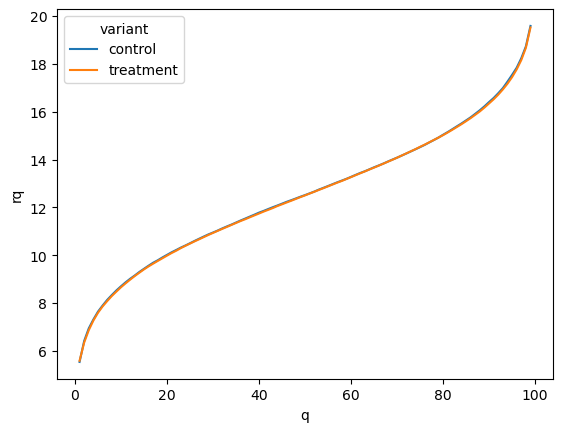

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data = df_variant_quantiles_pd, x= 'q', y = 'rq', hue = 'variant')